In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import numpy as np
import pandas as pd

Mounted at /content/gdrive


In [ ]:
cdf=pd.read_csv('gdrive/My Drive/crime_clean1_processed.csv')
wdf=pd.read_csv('gdrive/My Drive/weather_clean_processed.csv')

In [ ]:
wdf.info

<bound method DataFrame.info of       Unnamed: 0        Date  Wind speed (average for day)  Temp Min  \
0              0  01-01-2010                      1.670833      -0.6   
1              1  02-01-2010                      8.816667      -5.6   
2              2  03-01-2010                      9.566667      -8.9   
3              3  04-01-2010                      6.129167      -5.6   
4              4  05-01-2010                      5.529167      -3.9   
...          ...         ...                           ...       ...   
3647        3647  27-12-2019                      1.375000       5.6   
3648        3648  28-12-2019                      1.383333       3.3   
3649        3649  29-12-2019                      1.995833       5.6   
3650        3650  30-12-2019                      2.837500       8.3   
3651        3651  31-12-2019                      3.150000       5.6   

      Temp Max  Temp Average  Precip (Sum)  precip_intensity_<lambda>  \
0          6.1      1.791667  

In [ ]:
cdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42978 entries, 0 to 42977
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0.1       42978 non-null  int64 
 1   Unnamed: 0         42978 non-null  int64 
 2   Description        42978 non-null  object
 3   new_CrimeDateTime  42978 non-null  object
 4   District           42978 non-null  object
 5   size               42978 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 2.0+ MB


In [ ]:
#Dropping the unnecessary columns
cdf2=cdf.drop(columns=['Unnamed: 0'])
#Extracting the date from timestamp
cdf2['date'] = pd.to_datetime(cdf2['new_CrimeDateTime'], utc=True)

In [ ]:
#code source is Python Data Science Handbook by Jake VanderPlas pg. 401
#Identifying holidays in our dataset from 2010 to 2019, to analyze the data and conclude it
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2010','2019')

In [ ]:
# source https://stackoverflow.com/questions/29688899/pandas-checking-if-a-date-is-a-holiday-and-assigning-boolean-value
#Assigning boolean value if it's holiday '0', if not its '1'
cdf2['holiday'] = cdf2['date'].dt.date.astype('datetime64').isin(holidays)

In [ ]:
cdf2['day']=cdf2['date'].dt.day_name()

In [ ]:
wdf2=wdf.drop(columns=['Unnamed: 0'])

In [ ]:
#Extracting date and separating it into a column
wdf2['date'] = pd.to_datetime(wdf2['Date'], utc=True,dayfirst=True)

In [ ]:
#Merging the two datasets which are weather and crime datasets
mdf=cdf2.merge(right=wdf2,how='left',on='date')

In [ ]:
mdf2=mdf.drop(columns=['new_CrimeDateTime',"Date","District"])

In [ ]:
#mdf2['year'] = mdf2['date'].dt.year
mdf2['month'] = mdf2['date'].dt.month
mdf2['date_num'] = mdf2['date'].dt.day

In [ ]:
#https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca
#Incorporating cyclic patterns and transformations of the month and day features into the dataset.
#These features can potentially capture time-related variations or seasonal effects that might be useful for analysis or predictive modeling tasks.
#These calculations to transform the month and date values in mdf2 into normalized representations using cosine and sine functions
mdf2['month_norm'] = 2 * np.pi * mdf2['month']/ 12
mdf2["month_cos"] = np.cos(mdf2["month_norm"])
mdf2["month_sin"] = np.sin(mdf2["month_norm"])
mdf2['day_norm'] = 2 * np.pi * mdf2['date_num']/ 30
mdf2["date_cos"] = np.cos(mdf2["day_norm"])
mdf2["date_sin"] = np.sin(mdf2["day_norm"])

In [ ]:
mdf3=mdf2.drop(columns=['month','date_num','month_norm','day_norm'])

In [ ]:
#Checking for null values
mdf3.isnull().sum()

Unnamed: 0.1                     0
Description                      0
size                             0
date                             0
holiday                          0
day                              0
Wind speed (average for day)     0
Temp Min                         0
Temp Max                         0
Temp Average                     0
Precip (Sum)                     0
precip_intensity_<lambda>        0
cloudcover_<lambda>             13
tstorm_<lambda>                  0
winter_<lambda>                  0
mist_<lambda>                    0
fog_<lambda>                     0
month_cos                        0
month_sin                        0
date_cos                         0
date_sin                         0
dtype: int64

In [ ]:
mdf4=mdf3.drop('size', axis=1)
y=mdf3['size']

In [ ]:
y.isnull().sum()

0

In [ ]:
#df.rename(columns={"A": "a", "B": "c"}) https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html
mdf4.rename(columns={"Wind speed (average for day)":'WindSpAvg','precip_intensity_<lambda>':'PrecipInt','cloudcover_<lambda>':'Cloudcover',
                     'tstorm_<lambda>':'tstorm','winter_<lambda>':'winter',"mist_<lambda>":"mist",'fog_<lambda>':"fog"},inplace=True)

In [ ]:
# https://www.statology.org/pandas-convert-boolean-to-int/
mdf4.holiday = mdf4.holiday.replace({True: 1, False: 0})

In [ ]:
mdf4.head(3)

,Unnamed: 0.1,Description,date,holiday,day,WindSpAvg,Temp Min,Temp Max,Temp Average,Precip (Sum),PrecipInt,Cloudcover,tstorm,winter,mist,fog,month_cos,month_sin,date_cos,date_sin
0,0,BURGLARY,2013-12-25 00:00:00+00:00,1,Wednesday,2.466667,-7.8,-0.6,-4.058333,0.0,0,2.0,0,0,0,0,1.000000,-2.449294e-16,0.500000,-0.866025
1,1,LARCENY,2012-08-05 00:00:00+00:00,0,Sunday,3.920833,24.4,35.0,28.520833,0.0,0,2.0,0,0,0,0,-0.500000,-8.660254e-01,0.500000,0.866025
2,2,LARCENY FROM AUTO,2019-11-08 00:00:00+00:00,0,Friday,4.720833,2.2,11.1,5.662500,0.6,0,2.0,0,0,0,0,0.866025,-5.000000e-01,-0.104528,0.994522


In [ ]:
mdf4.shape

(42978, 20)

In [ ]:
mdf4.drop(columns=['date'], inplace=True)

In [ ]:
mdf4.sort_values(by='PrecipInt',ascending=False).head()

,Unnamed: 0.1,Description,holiday,day,WindSpAvg,Temp Min,Temp Max,Temp Average,Precip (Sum),PrecipInt,Cloudcover,tstorm,winter,mist,fog,month_cos,month_sin,date_cos,date_sin
14751,18904,COMMON ASSAULT,0,Monday,7.420833,8.9,12.2,10.937500,122.0,3,4.0,0,0,1,0,0.500000,-0.866025,0.978148,-0.207912
38341,53301,ARSON,0,Saturday,7.679167,-6.1,-2.2,-4.233333,49.9,3,5.0,0,1,0,0,0.866025,0.500000,0.104528,-0.994522
16917,22132,ROBBERY - COMMERCIAL,0,Saturday,7.679167,-6.1,-2.2,-4.233333,49.9,3,5.0,0,1,0,0,0.866025,0.500000,0.104528,-0.994522
18620,24403,ROBBERY,0,Monday,7.420833,8.9,12.2,10.937500,122.0,3,4.0,0,0,1,0,0.500000,-0.866025,0.978148,-0.207912
38343,53303,AGG. ASSAULT,0,Saturday,7.679167,-6.1,-2.2,-4.233333,49.9,3,5.0,0,1,0,0,0.866025,0.500000,0.104528,-0.994522


In [ ]:
#To handle missing values in the columns by either replacing them with the mean value or the mode of the available data.
mdf4['WindSpAvg'].fillna(mdf4['WindSpAvg'].mean(), inplace=True)
mdf4['Temp Min'].fillna(mdf4['Temp Min'].mean(), inplace=True)
mdf4['Temp Max'].fillna(mdf4['Temp Max'].mean(), inplace=True)
mdf4['Temp Average'].fillna(mdf4['Temp Average'].mean(), inplace=True)
mdf4['PrecipInt'].fillna(mdf4['PrecipInt'].mode()[0], inplace=True)
mdf4['Cloudcover'].fillna(mdf4['Cloudcover'].mode()[0], inplace=True)
mdf4['tstorm'].fillna(mdf4['tstorm'].mode()[0], inplace=True)
mdf4['winter'].fillna(mdf4['winter'].mode()[0], inplace=True)
mdf4['mist'].fillna(mdf4['mist'].mode()[0], inplace=True)
mdf4['fog'].fillna(mdf4['fog'].mode()[0], inplace=True)
mdf4['Precip (Sum)'].fillna(mdf4['Precip (Sum)'].mean(), inplace=True)


In [ ]:
mdf4.isnull().sum()

Unnamed: 0.1    0
Description     0
holiday         0
day             0
WindSpAvg       0
Temp Min        0
Temp Max        0
Temp Average    0
Precip (Sum)    0
PrecipInt       0
Cloudcover      0
tstorm          0
winter          0
mist            0
fog             0
month_cos       0
month_sin       0
date_cos        0
date_sin        0
dtype: int64

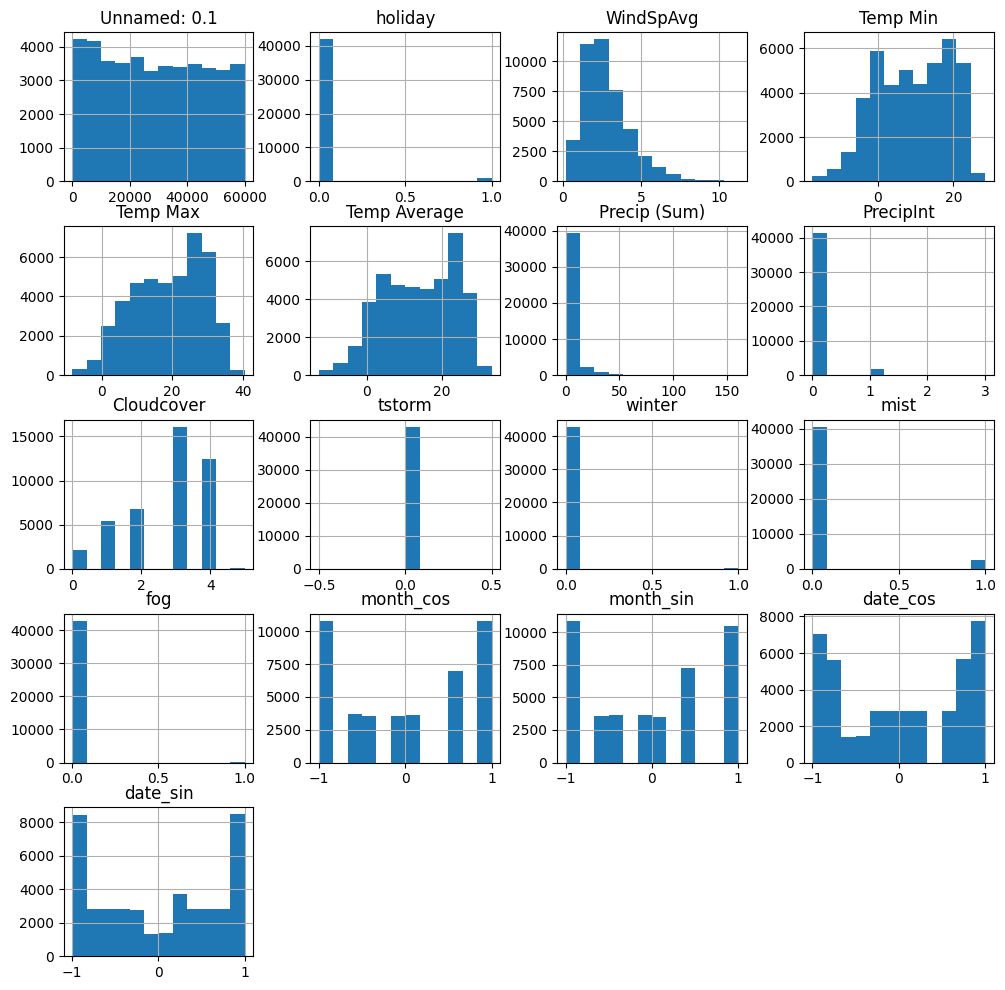

In [ ]:
#Sub plots to see the skewness of an attribute
import matplotlib.pyplot as plt

mdf4.hist(bins=12,figsize=(12,12))
plt.show()

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (OneHotEncoder, StandardScaler,
                                   FunctionTransformer, MinMaxScaler,RobustScaler,QuantileTransformer)
from sklearn.pipeline import Pipeline, make_pipeline

In [ ]:
#Applying transformations to specific columns of a dataset
preprocessTransformer = ColumnTransformer(
    [ ('WindSpeedTransform', RobustScaler(), ["WindSpAvg"]),
      ('TempTransform', StandardScaler(), ["Temp Min",'Temp Max',"Temp Average",'month_cos','month_sin','date_cos','date_sin']),
     ('precipTransform',make_pipeline(QuantileTransformer(n_quantiles=100, output_distribution='normal'),RobustScaler()),['Precip (Sum)']),
     ("OneHotTransform",OneHotEncoder(),["Description",'day','PrecipInt','Cloudcover']),
     ('weatherTransform', 'passthrough', ['holiday',"tstorm",'winter','mist','fog'])])

In [ ]:
#Undergoing the preprocessing resulting transformed data is assigned to the variable X
p = Pipeline([('preprocess', preprocessTransformer)])

X = p.fit_transform(mdf4)

In [ ]:
pd.DataFrame(X).sort_values(by=35)

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
21488,3.894009,-2.134268,-2.449202,-2.335088,1.225861,0.718028,-0.458225,-1.362656,0.000000,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27383,-0.320276,1.189961,0.861636,0.997552,0.709002,-1.216845,-0.171050,1.409310,0.000000,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
27384,0.359447,1.011690,0.802160,0.980724,0.709002,-1.216845,0.122541,1.409310,0.000000,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27385,0.359447,1.011690,0.802160,0.980724,0.709002,-1.216845,0.122541,1.409310,0.000000,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27386,0.359447,1.011690,0.802160,0.980724,0.709002,-1.216845,0.122541,1.409310,0.000000,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23528,-0.170507,1.766719,1.902469,1.891117,-1.219943,-0.698398,0.122541,-1.424584,1.001785,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4743,-0.237327,1.305312,1.297795,1.325034,-0.703084,-1.216845,-0.171050,1.409310,0.000000,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27204,-0.188940,-1.379238,-0.129633,-0.777066,0.709002,1.236476,1.111895,-0.845085,0.000000,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27203,-0.188940,-1.379238,-0.129633,-0.777066,0.709002,1.236476,1.111895,-0.845085,0.000000,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Extends columns list with additional column names after applying a pipeline transformation
columns = ["WindSpAvg",'Temp Min',"Temp Max",'Temp Average','month_cos','month_sin','date_cos','date_sin','Precip (Sum)']
columns.extend([c
               for c in p.named_steps['preprocess']
               .named_transformers_['OneHotTransform']
               .get_feature_names_out(["Description",'day','PrecipInt','Cloudcover'])])
columns.extend(['holiday','tstorms','winter','mist','fog'])

In [ ]:
X.shape

(42978, 44)

In [ ]:
mdf_tnf = pd.DataFrame(X, columns=columns)
mdf_tnf

,WindSpAvg,Temp Min,Temp Max,Temp Average,month_cos,month_sin,date_cos,date_sin,Precip (Sum),Description_AGG. ASSAULT,...,Cloudcover_1.0,Cloudcover_2.0,Cloudcover_3.0,Cloudcover_4.0,Cloudcover_5.0,holiday,tstorms,winter,mist,fog
0,-0.020737,-1.788213,-1.953567,-1.856593,1.415045,0.009815,0.677925,-1.241508,0.000000,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.783410,1.588449,1.575350,1.517036,-0.703084,-1.216845,0.677925,1.226235,0.000000,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.225806,-0.739560,-0.793783,-0.849984,1.225861,-0.698398,-0.171050,1.409310,0.977771,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.025346,-0.561289,-0.466664,-0.375372,-0.703084,1.236476,1.111895,-0.845085,0.000000,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.755760,-1.085616,-0.625267,-0.919018,0.709002,-1.216845,1.349415,0.288586,0.000000,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42973,-0.181475,1.242393,1.248231,1.253928,-1.219943,-0.698398,-0.963954,1.051160,0.000000,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42974,-0.181475,1.242393,1.248231,1.253928,-1.219943,-0.698398,-0.963954,1.051160,0.000000,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42975,-0.181475,1.242393,1.248231,1.253928,-1.219943,-0.698398,-0.963954,1.051160,0.000000,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42976,-0.181475,1.242393,1.248231,1.253928,-1.219943,-0.698398,-0.963954,1.051160,0.000000,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
y.shape

(42978,)

In [ ]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:


# Split data into training and testing sets
X = mdf_tnf

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:


# Define the regression models to use
linear_reg = LinearRegression()
decision_tree_reg = DecisionTreeRegressor()
random_forest_reg = RandomForestRegressor()
xgb_reg = XGBRegressor()
lgbm_reg = LGBMRegressor()
# Train and evaluate the models


In [ ]:
linear_reg.fit(X_train, y_train)

# Make predictions on testing data
y_pred = linear_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"Liear Regression Metrics: MSE = {mse:.2f}, MAE = {mae:.2f}, R^2 = {r2:.2f}")

Liear Regression Metrics: MSE = 2.73, MAE = 0.94, R^2 = 0.44


In [ ]:
decision_tree_reg.fit(X_train, y_train)

# Make predictions on testing data
y_pred = decision_tree_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"Decision Tree Regression Metrics: MSE = {mse:.2f}, MAE = {mae:.2f}, R^2 = {r2:.2f}")

Decision Tree Regression Metrics: MSE = 4.93, MAE = 1.26, R^2 = -0.00


In [ ]:
random_forest_reg.fit(X_train, y_train)

# Make predictions on testing data
y_pred = random_forest_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"Random forest Regression Metrics: MSE = {mse:.2f}, MAE = {mae:.2f}, R^2 = {r2:.2f}")

Random forest Regression Metrics: MSE = 2.83, MAE = 0.96, R^2 = 0.42


In [ ]:
random_forest_reg.fit(X_train, y_train)

# Make predictions on testing data
y_pred = random_forest_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"Random forest Regression Metrics: MSE = {mse:.2f}, MAE = {mae:.2f}, R^2 = {r2:.2f}")

Random forest Regression Metrics: MSE = 2.12, MAE = 0.92, R^2 = 0.44


In [ ]:
xgb_reg.fit(X_train, y_train)

# Make predictions on testing data
y_pred = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"XGBoost Regression Metrics: MSE = {mse:.2f}, MAE = {mae:.2f}, R^2 = {r2:.2f}")

XGBoost Regression Metrics: MSE = 2.76, MAE = 0.96, R^2 = 0.44


In [ ]:

lgbm_reg.fit(X_train, y_train)

# Make predictions on testing data
y_pred = lgbm_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"LGBM Regression Metrics: MSE = {mse:.2f}, MAE = {mae:.2f}, R^2 = {r2:.2f}")

LGBM Regression Metrics: MSE = 2.69, MAE = 0.93, R^2 = 0.45


In [ ]:

from sklearn.linear_model import Ridge
ridge = Ridge()

ridge.fit(X_train, y_train)

# Make predictions on testing data
y_pred = ridge.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f" Ridge Regression Metrics: MSE = {mse:.2f}, MAE = {mae:.2f}, R^2 = {r2:.2f}")

 Ridge Regression Metrics: MSE = 2.73, MAE = 0.94, R^2 = 0.44


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)

# Make predictions on testing data
y_pred = gbr.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f" Gradient boosting  Regression Metrics: MSE = {mse:.2f}, MAE = {mae:.2f}, R^2 = {r2:.2f}")

 Gradient boosting  Regression Metrics: MSE = 2.70, MAE = 0.94, R^2 = 0.45


In [ ]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor()
mlp.fit(X_train, y_train)

# Make predictions on testing data
y_pred = mlp.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f" MLP  Regression Metrics: MSE = {mse:.2f}, MAE = {mae:.2f}, R^2 = {r2:.2f}")


 MLP  Regression Metrics: MSE = 2.82, MAE = 0.98, R^2 = 0.43


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


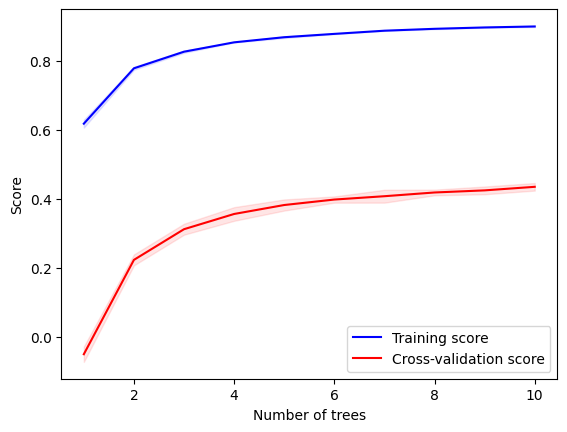

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import validation_curve
import numpy as np

# Define the hyperparameter values to test
param_range = np.arange(1, 11)

model1 = RandomForestRegressor()

# Calculate the validation scores for each hyperparameter value
train_scores, test_scores = validation_curve(
    estimator=model1,
    X=X_train,
    y=y_train,
    param_name='n_estimators',
    param_range=param_range,
    cv=5
)

# Calculate the mean and standard deviation of the training and test scores for each hyperparameter value
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.plot(param_range, train_mean, label='Training score', color='blue')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(param_range, test_mean, label='Cross-validation score', color='red')
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.1, color='red')
plt.xlabel('Number of trees')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()


In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Set the range of fold numbers to try
n_folds = range(2, 11)
# Create an empty list to store the mean cross-validation scores
cv_scores = []
# Loop over the range of fold numbers and calculate the mean cross-validation score for each
for n in n_folds:
    scores = cross_val_score(model1, X_train, y_train, cv=n)
    mean_score = np.mean(scores)
    cv_scores.append(mean_score)
# Print the mean cross-validation scores for each fold number
for n, score in zip(n_folds, cv_scores):
    print("Fold: {}, Mean CV Score: {:.3f}".format(n, score))


Fold: 2, Mean CV Score: 0.476
Fold: 3, Mean CV Score: 0.477
Fold: 4, Mean CV Score: 0.477
Fold: 5, Mean CV Score: 0.479
Fold: 6, Mean CV Score: 0.478
Fold: 7, Mean CV Score: 0.479
Fold: 8, Mean CV Score: 0.478
Fold: 9, Mean CV Score: 0.478
Fold: 10, Mean CV Score: 0.479


In [ ]:
#Fold: 8, Mean CV Score: 0.523 it has higher cv score


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split



# Perform K-fold cross-validation and get the scores
scores = cross_val_score(model1, X_train, y_train, cv=5)

# Print the scores for each fold
print('Cross-validation scores:', scores)

# Fit the classifier to the training data and test it on the testing data
model1.fit(X_train, y_train)
test_score = model1.score(X_test, y_test)
print('Test score:', test_score)


Cross-validation scores: [0.49248748 0.47760639 0.47100205 0.46443108 0.48889243]
Test score: 0.4261247752036442
